In [5]:
import numpy as np 
import plot_utils as p
from task import Task

%matplotlib inline

In [7]:
import reward_functions as rfns

def target_fn(task):
    # Huge crash penalty
    if task.sim.pose[2] <= 0:
        return -100
    delta_target = task.target_pos - task.sim.pose[:3]
    #Any deviation from no rotations is bad
    ang_vel_penalty = -(abs(task.sim.angular_v)).sum()
    #Any radial error is bad
    radial_error_penalty = -(np.linalg.norm(delta_target[:2]))
    #Any effort at all going up is very good. 
    # * 1000 seems excessive, but when we're talking mm at launch we need some sort of big reward
    # z_reward = 1.0 / np.abs(delta_target[2])
    z_reward = 1.0 / delta_target[2] ** 2
    return (z_reward + ang_vel_penalty + radial_error_penalty) / 10.0
              
takeoff_task = Task(init_pose=np.array([0., 0., 0., 0., 0., 0.]),   # initial pose, 
                    init_velocities=np.array([0., 0., 0.]),         # initial velocities 
                    init_angle_velocities=np.array([0., 0., 0.]),   # initial angle velocities
                    runtime=5.0,                                    # time limit of the episode
                    target_pos=np.array([0., 0., 10.]),             # Desired final position
                    reward_fn=target_fn,
                    action_repeat=3)

In [8]:
#Note that for this to work you need to open a terminal and pip install keras-rl
from agents.keras_ddpg import build_agent
#Create an agent using the keras-rl API
takeoff_agent = build_agent(takeoff_task.state_size, 
                            takeoff_task.action_size, 
                            takeoff_task.action_low, 
                            takeoff_task.action_high)

Using TensorFlow backend.


In [9]:
print(takeoff_task.action_low)
print(takeoff_task.action_high)

0
900


In [20]:
visualize=False
verbose=1
#Number of training steps to be performed.
#num_training_steps=50000
num_training_steps=5000
#0 for no logging, 1, for interval logging, or 2 for episode logging
verbose=1
#Number of steps per episode that the agent performs before automatically resetting the environment.
max_episode_steps=200
takeoff_agent.fit(takeoff_task, 
                  nb_steps=num_training_steps, 
                  visualize=visualize, 
                  verbose=verbose, 
                  nb_max_episode_steps=max_episode_steps,
                  action_repetition=1,
                  nb_max_start_steps=3,
                  start_step_policy=lambda x: [800, 800, 800, 800]
                 )

Training for 5000 steps ...
Interval 1 (0 steps performed)
 4996/10000 [=============>................] - ETA: 21s - reward: -42.1511done, took 21.741 seconds


In [16]:
def eval_episode(task, agent):
    labels = ['time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
              'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
              'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4', 'reward']
    results = {x : [] for x in labels}

    state = task.reset() # start a new episode
    while True:
        rotor_speeds = agent.forward(state) 
        next_state, reward, done, _ = task.step(rotor_speeds)
        to_write = [task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(rotor_speeds) + [reward]
        for ii in range(len(labels)):
            results[labels[ii]].append(to_write[ii])
        #writer.writerow(to_write)
        state = next_state
        if done:
            break
    return results

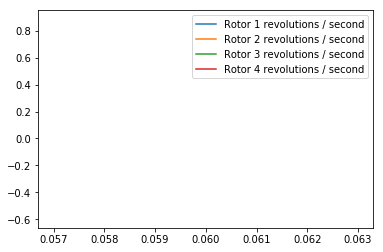

In [17]:
takeoff_results = eval_episode(takeoff_task, takeoff_agent)
p.plot_actions(takeoff_results)

## Plot the Rewards

Once you are satisfied with your performance, plot the episode rewards, either from a single run, or averaged over multiple runs. 

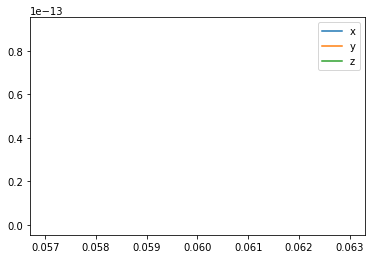

In [18]:
p.plot_pos(takeoff_results)

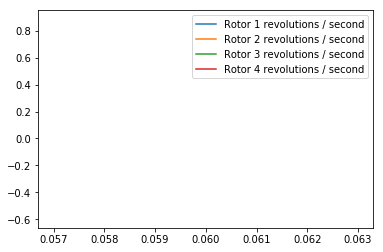

In [19]:
p.plot_actions(takeoff_results)